## Carvana Challenge EDA

Start by adding the helper files to the python path

In [1]:
import sys

sys.path.append('../src')

Add required imports

In [2]:
from data.fetcher import DatasetFetcher as DatasetHandler
import pandas as pd
import os

from PIL import Image
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns 

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

### Download the dataset

In [3]:
train_data, test_data, metadata_csv, train_masks_csv, train_masks_data = DatasetHandler().download_dataset()

All datasets are present.


Show csv data informations:

In [4]:
metadata_df = pd.read_csv(metadata_csv)
train_masks_df = pd.read_csv(train_masks_csv)

In [5]:
metadata_df.head()

,id,boneage,male
0,1377,180,False
1,1378,12,False
2,1379,94,False
3,1380,120,True
4,1381,82,False


In [6]:
train_masks_df.head()

,Case ID,Sex
0,4360,M
1,4361,M
2,4362,M
3,4363,M
4,4364,M


Count train/test data:

In [7]:
train_files = os.listdir(train_data)
test_files = os.listdir(test_data)
train_masks_files = os.listdir(train_masks_data)x
print("Train files count: {}\nTrain masks files count: {}\nTest files count: {}"
      .format(len(train_files), len(train_masks_files), len(test_files)))

Train files count: 104
Train masks files count: 104
Test files count: 12707


Get unique ids (each car has 16 images from different angles):

In [18]:
train_ids = list(set(t.split("_")[0] for t in train_files))
masks_ids = list(set(t.split("_")[0] for t in train_masks_files))
test_ids = list(set(t.split("_")[0] for t in test_files))

print("Train files unique ids count: {}\nMask files unique ids count: {}\nTest files unique ids count: {}".format(len(train_ids), len(masks_ids), len(test_ids)))

Train files unique ids count: 104
Mask files unique ids count: 104
Test files unique ids count: 12707


## Utility functions

Create a function to get car images path from their ID and another one to open the image and return a numpy matrix.

In [28]:
def get_car_image_files(car_image_id, get_mask=False):
    if get_mask:
        if car_image_id in masks_ids:
            return [train_masks_data + "/" + s for s in train_masks_files if car_image_id in s]
        else:
            raise Exception("No mask with this ID found")
    elif car_image_id in train_ids:
        return [train_data + "/" + s for s in train_files if car_image_id in s]
    elif car_image_id in test_ids:
        return [test_data + "/" + s for s in test_files if car_image_id in s]
    raise Exception("No image with this ID found")
    
def get_image_matrix(image_path):
    img = Image.open(image_path)
    return np.asarray(img, dtype=np.uint8)

## Display a single car with its mask

1478.png
(2044, 1514)
(2044, 1514, 3)
Image shape: (2044, 1514) | image type: uint8 | mask shape: (2044, 1514) | mask type: uint8


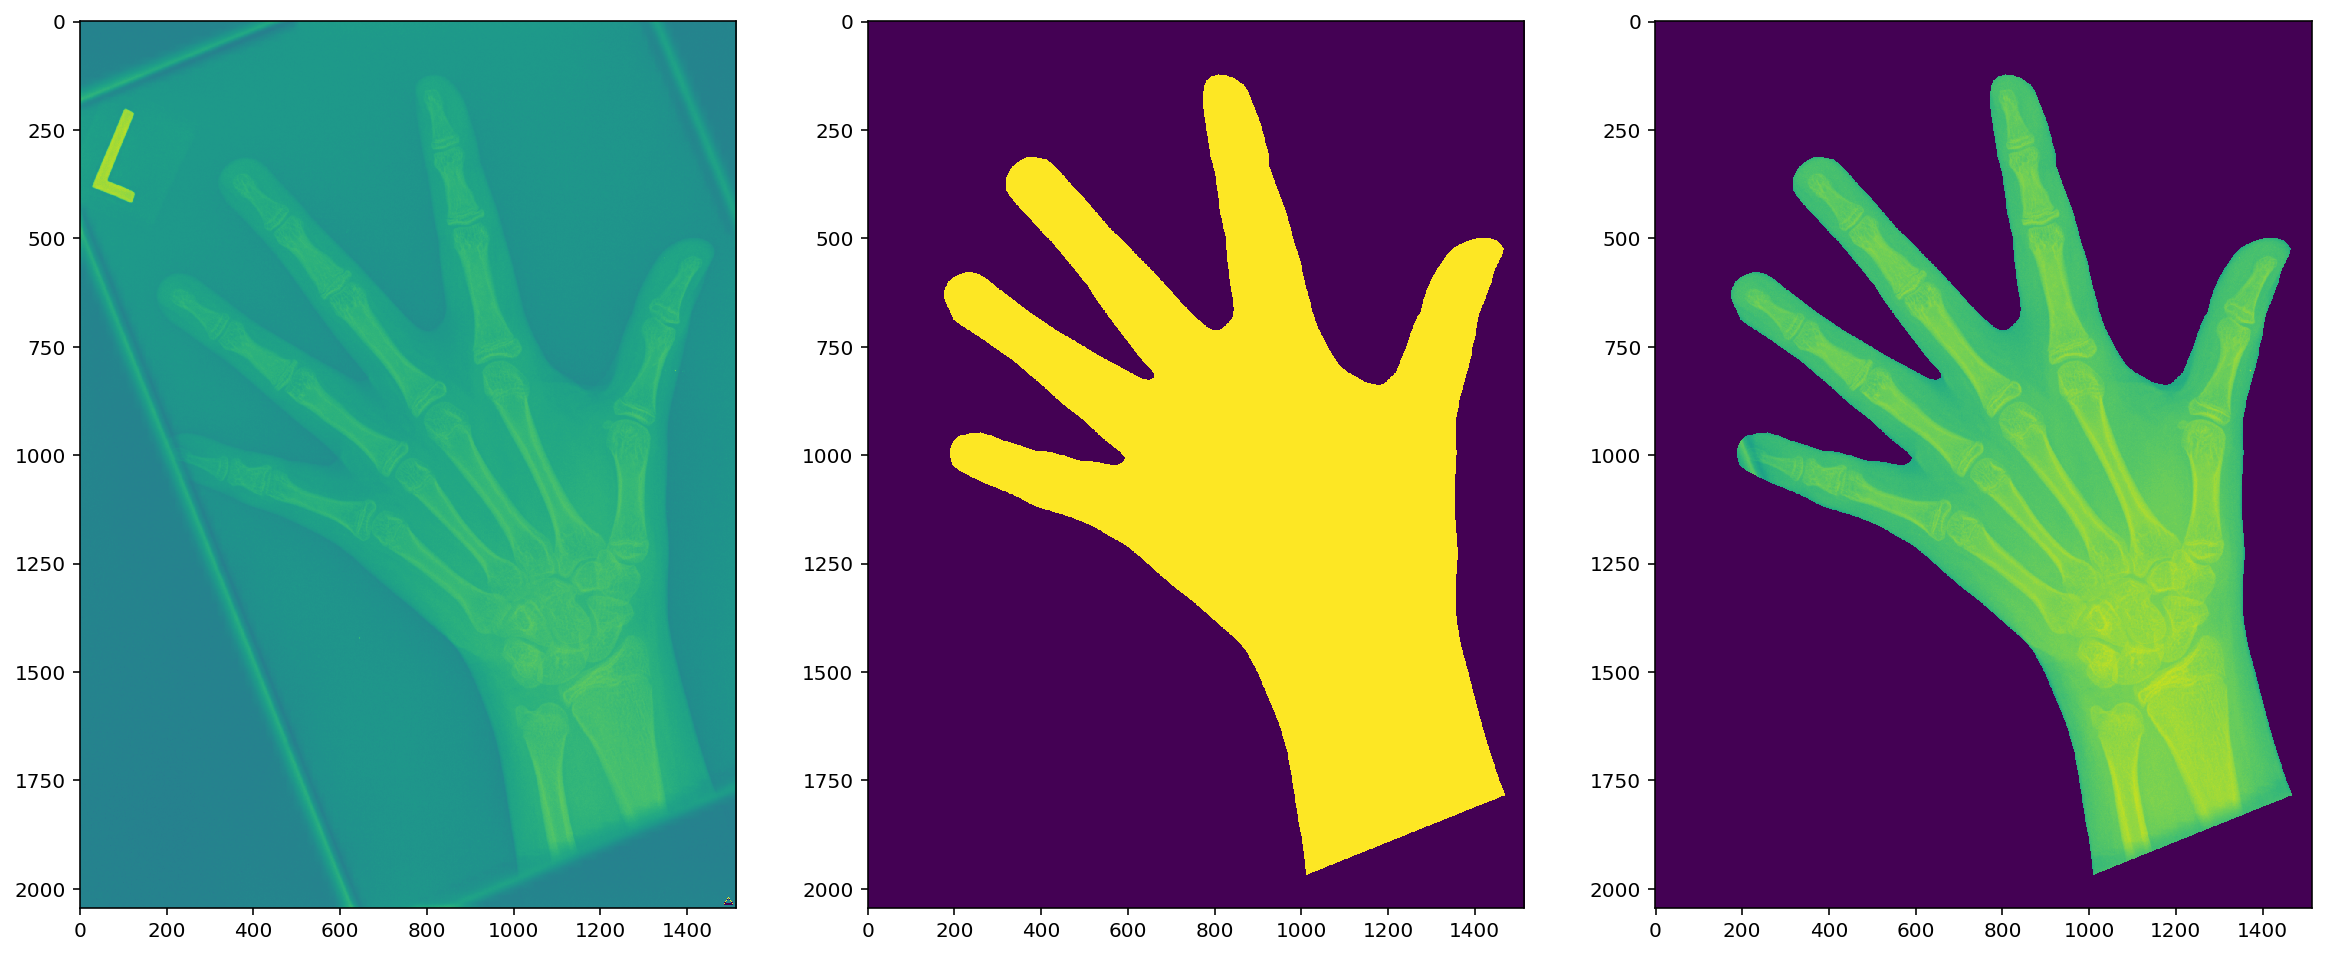

In [29]:
image_id = train_ids[0]
print(image_id)
plt.figure(figsize=(20, 20))
img = get_image_matrix(get_car_image_files(image_id)[0])
mask = get_image_matrix(get_car_image_files(image_id, True)[0])
print(img.shape)
print(mask.shape)
plt.subplot(131)
plt.imshow(img)
mask = mask[:, :, 1]
plt.subplot(132)
plt.imshow(mask)

img_masked = cv2.bitwise_and(img, img, mask=mask)

print("Image shape: {} | image type: {} | mask shape: {} | mask type: {}"
      .format(img.shape, img.dtype, mask.shape, mask.dtype) )

plt.subplot(133)
plt.imshow(img_masked);

## Check train mask DataFrame
Check that the retrived mask indices corresponds to the ones in the csv file by checking the rle signatures

In [ ]:
def rle_encode(mask_image):
    pixels = mask_image.flatten()
    # We avoid issues with '1' at the start or end (at the corners of 
    # the original image) by setting those pixels to '0' explicitly.
    # We do not expect these to be non-zero for an accurate mask, 
    # so this should not harm the score.
    pixels[0] = 0
    pixels[-1] = 0
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 2
    runs[1::2] = runs[1::2] - runs[:-1:2]
    return runs

def rle_to_string(runs):
    return ' '.join(str(x) for x in runs)

file_name = get_car_image_files(image_id)[0].split("/")[-1]
mask_rle = train_masks_df[train_masks_df['img'] == file_name]["rle_mask"].iloc[0]
assert rle_to_string(rle_encode(mask)) == mask_rle, "Mask rle don't match"
print("Mask rle match!")

## Display few random cars from train dataset

In [ ]:
images_path = [get_car_image_files(id) for id in train_ids[:5]]

for i, angles in enumerate(images_path):
    _, axs = plt.subplots(4, 4, figsize=(14, 10))  #  figsize=(20, 20)
    plt.rc('axes', grid=False)
    plt.subplots_adjust(wspace=0, hspace=0)
    axs = axs.ravel()
    
    for j, img_path in enumerate(angles):
        img = mpimg.imread(img_path)
        axs[j].axis('off')
        axs[j].imshow(img);

## How many different cars in the dataset

In [ ]:
plt.figure(figsize=(12, 10))
sns.countplot(y="male", data=metadata_df);